In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
import cv2
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [ ]:
project_name = "FER_2013_Emotion_Detection"
model_name = [
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Augmentation',
    'VGG16_Transfer_Learning',
    'ResNet50_Transfer_Learning'
]
base_dir = '/content/'
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)
for each_model in model_name:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok=True)

print(f"Project Directory Created at {project_dir}")

image_exts = ['jpeg', 'jpg', 'png']
data_dir = '/content/train'
for root, dirs, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            img = cv2.imread(file_path)
            if img is None:
                print(f'Invalid image file {file_path}')
                os.remove(file_path)
        except Exception as e:
            print(f'Issue with image {file_path}')
            os.remove(file_path)

Project Directory Created at /content/FER_2013_Emotion_Detection


       surprise  neutral  happy  fear  disgust   sad  angry
train      3171     4965   7215  4097      436  4830   3995
      surprise  neutral  happy  fear  disgust   sad  angry
test       831     1233   1774  1024      111  1247    958


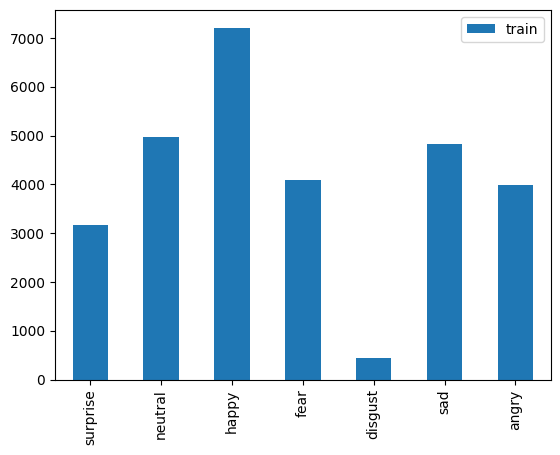

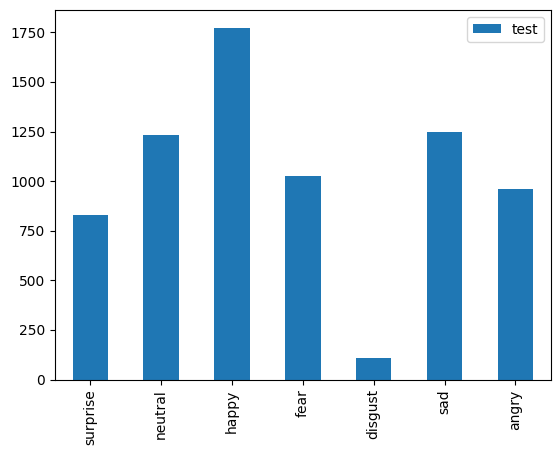

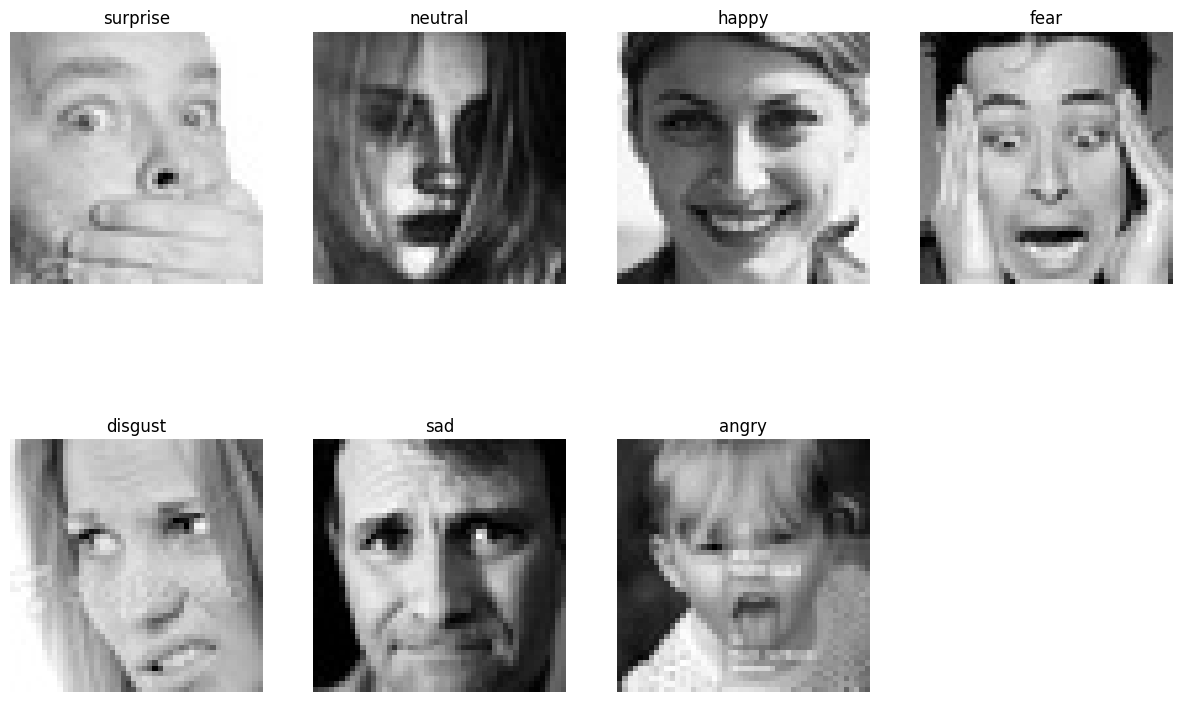

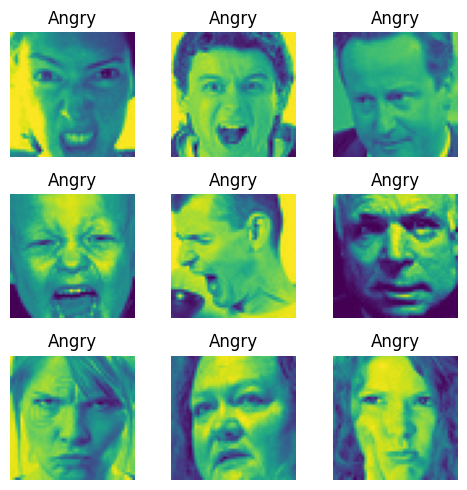

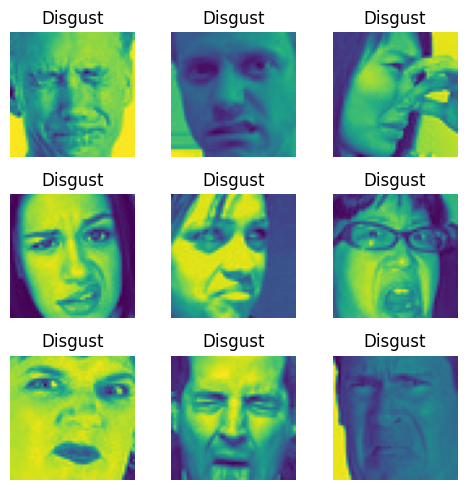

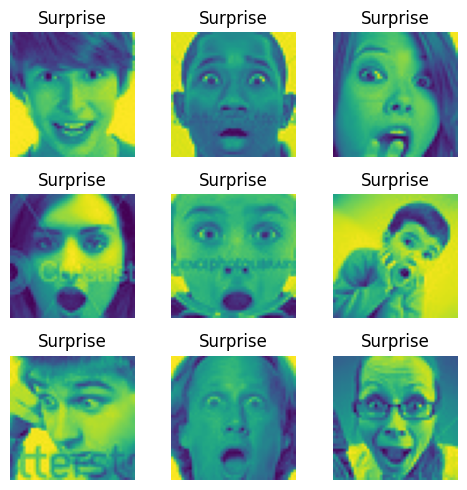

In [ ]:
def count_files_in_subdirs(directory, set_name):
    counts = {}
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path):
            count = len([file for file in os.listdir(item_path) if os.path.isfile(os.path.join(item_path, file))])
            counts[item] = count
    df = pd.DataFrame(counts, index=[set_name])
    return df

train_dir = '/content/train'
test_dir = '/content/test'

train_count = count_files_in_subdirs(train_dir, 'train')
test_count = count_files_in_subdirs(test_dir, 'test')
print(train_count)
print(test_count)

train_count.transpose().plot(kind='bar')
test_count.transpose().plot(kind='bar')

emotions = os.listdir(train_dir)
plt.figure(figsize=(15, 15))
for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    ax = plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

def plot_images_from_directory(directory_path, class_name, num_images=9):
    image_filenames = os.listdir(directory_path)
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}")
        num_images = len(image_filenames)
    selected_images = random.sample(image_filenames, num_images)
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))
    axes = axes.flatten()
    for i, img_name in enumerate(selected_images):
        img_path = os.path.join(directory_path, img_name)
        image = Image.open(img_path)
        axes[i].imshow(image)
        axes[i].set_title(class_name)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

angry_directory_path = '/content/train/angry'
plot_images_from_directory(angry_directory_path, class_name='Angry')

disgust_directory_path = '/content/train/disgust'
plot_images_from_directory(disgust_directory_path, class_name='Disgust')

surprise_directory_path = '/content/train/surprise'
plot_images_from_directory(surprise_directory_path, class_name='Surprise')

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            for img_name in os.listdir(cls_dir):
                img_path = os.path.join(cls_dir, img_name)
                images.append((img_path, self.class_to_idx[cls]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = EmotionDataset(train_dir, transform=transform)
test_dataset = EmotionDataset(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.dropout2 = nn.Dropout(0.25)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(512)
        self.dropout3 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(512 * 6 * 6, 1024)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv2(nn.functional.relu(self.conv1(x)))))
        x = self.bn1(x)
        x = self.dropout1(x)

        x = self.pool(nn.functional.relu(self.conv4(nn.functional.relu(self.conv3(x)))))
        x = self.bn2(x)
        x = self.dropout2(x)

        x = self.pool(nn.functional.relu(self.conv6(nn.functional.relu(self.conv5(x)))))
        x = self.bn3(x)
        x = self.dropout3(x)

        x = x.view(-1, 512 * 6 * 6)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        return x

model = EmotionCNN(num_classes=7)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10, Loss: 1.5303, Accuracy: 40.62%
Epoch 2/10, Loss: 1.2599, Accuracy: 52.01%
Epoch 3/10, Loss: 1.1068, Accuracy: 58.53%
Epoch 4/10, Loss: 0.9801, Accuracy: 63.56%
Epoch 5/10, Loss: 0.8381, Accuracy: 69.06%
Epoch 6/10, Loss: 0.7129, Accuracy: 74.36%
Epoch 7/10, Loss: 0.5804, Accuracy: 79.62%
Epoch 8/10, Loss: 0.4668, Accuracy: 83.44%
Epoch 9/10, Loss: 0.3759, Accuracy: 87.19%
Epoch 10/10, Loss: 0.2914, Accuracy: 90.35%


Test Accuracy: 64.17%


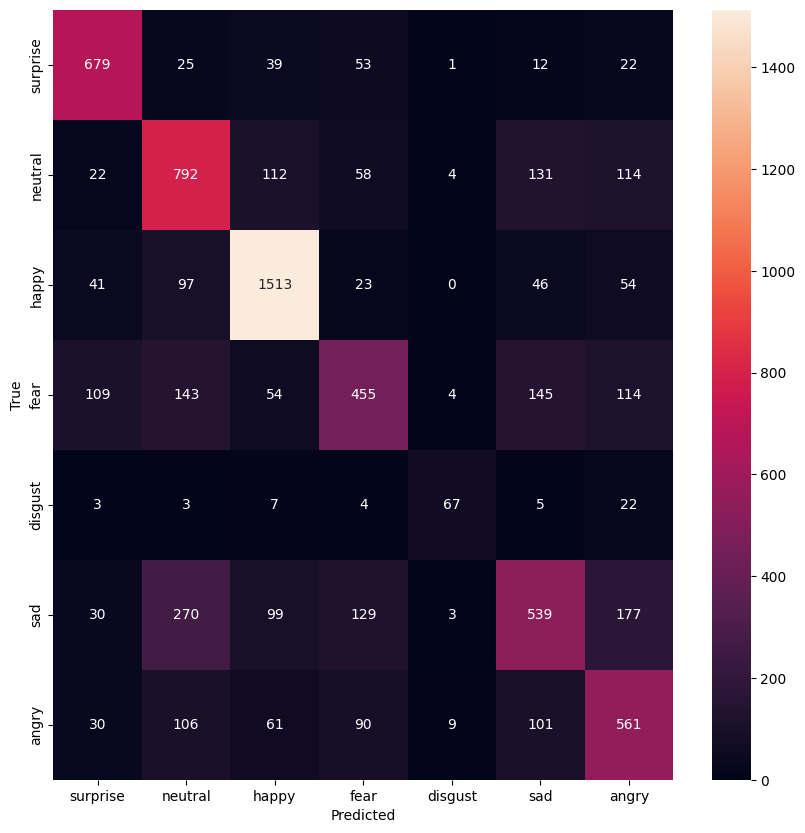

              precision    recall  f1-score   support

    surprise       0.74      0.82      0.78       831
     neutral       0.55      0.64      0.59      1233
       happy       0.80      0.85      0.83      1774
        fear       0.56      0.44      0.50      1024
     disgust       0.76      0.60      0.67       111
         sad       0.55      0.43      0.48      1247
       angry       0.53      0.59      0.55       958

    accuracy                           0.64      7178
   macro avg       0.64      0.63      0.63      7178
weighted avg       0.64      0.64      0.64      7178



In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100. * correct / total
    print(f'Test Accuracy: {test_acc:.2f}%')
    return all_preds, all_labels

all_preds, all_labels = evaluate_model(model, test_loader)

class_labels = list(train_dataset.class_to_idx.keys())
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

report = classification_report(all_labels, all_preds, target_names=class_labels)
print(report)

In [ ]:
augment_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

augmented_train_dataset = EmotionDataset(train_dir, transform=augment_transform)
augmented_train_loader = DataLoader(augmented_train_dataset, batch_size=64, shuffle=True)

train_model(model, augmented_train_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10, Loss: 1.2092, Accuracy: 54.99%
Epoch 2/10, Loss: 1.1109, Accuracy: 58.41%
Epoch 3/10, Loss: 1.0570, Accuracy: 60.14%
Epoch 4/10, Loss: 1.0329, Accuracy: 61.18%
Epoch 5/10, Loss: 1.0021, Accuracy: 62.44%
Epoch 6/10, Loss: 0.9752, Accuracy: 63.59%
Epoch 7/10, Loss: 0.9611, Accuracy: 63.99%
Epoch 8/10, Loss: 0.9330, Accuracy: 65.69%
Epoch 9/10, Loss: 0.9206, Accuracy: 65.42%
Epoch 10/10, Loss: 0.8965, Accuracy: 66.81%


In [ ]:
vgg16 = models.vgg16(pretrained=True)
vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)  # Modify first layer for grayscale
vgg16.classifier[6] = nn.Linear(4096, 7)  # Modify last layer for 7 classes

vgg16 = vgg16.to(device)
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001)

train_model(vgg16, train_loader, criterion, optimizer, num_epochs=10)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 87.0MB/s]


Epoch 1/10, Loss: 1.5569, Accuracy: 38.01%
Epoch 2/10, Loss: 1.2085, Accuracy: 53.84%
Epoch 3/10, Loss: 1.0459, Accuracy: 60.78%
Epoch 4/10, Loss: 0.8803, Accuracy: 67.49%
Epoch 5/10, Loss: 0.7303, Accuracy: 73.41%
Epoch 6/10, Loss: 0.5468, Accuracy: 80.64%
Epoch 7/10, Loss: 0.3956, Accuracy: 86.39%
Epoch 8/10, Loss: 0.2847, Accuracy: 90.42%
Epoch 9/10, Loss: 0.2062, Accuracy: 93.08%
Epoch 10/10, Loss: 0.1651, Accuracy: 94.60%


In [ ]:
resnet50 = models.resnet50(pretrained=True)
resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Modify first layer for grayscale
resnet50.fc = nn.Linear(2048, 7)  # Modify last layer for 7 classes

resnet50 = resnet50.to(device)
optimizer = optim.Adam(resnet50.parameters(), lr=0.0001)

train_model(resnet50, train_loader, criterion, optimizer, num_epochs=10)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 207MB/s]


Epoch 1/10, Loss: 1.6025, Accuracy: 37.16%
Epoch 2/10, Loss: 1.2486, Accuracy: 53.22%
Epoch 3/10, Loss: 0.9613, Accuracy: 64.72%
Epoch 4/10, Loss: 0.6796, Accuracy: 75.51%
Epoch 5/10, Loss: 0.4567, Accuracy: 83.73%
Epoch 6/10, Loss: 0.3218, Accuracy: 88.66%
Epoch 7/10, Loss: 0.2236, Accuracy: 92.42%
Epoch 8/10, Loss: 0.2005, Accuracy: 93.14%
Epoch 9/10, Loss: 0.1585, Accuracy: 94.55%
Epoch 10/10, Loss: 0.1469, Accuracy: 94.88%
